In [1]:
%load_ext autoreload
%autoreload 1

In [34]:
# Familiar imports
import numpy as np
import pandas as pd

# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# For training random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import os
from os import path
import random
# import zipfile
import tqdm
%aimport common
%aimport common_prediction
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from datetime import datetime, timedelta
import itertools
import json
import functools
from IPython.display import HTML
import time
import logging
from IPython.display import display
import lightgbm as lgb
import optuna
import hashlib

FN = path.join(os.getcwd(),"20210817-30-days-ml.ipynb")
STOPFILE_FN = ".optuna.stopfile"

In [3]:
X,y,X_test = common.setup()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [22]:
search_space

{'learning_rate': ['float', [0.01, 1], {'log': True}],
 'n_estimators': ['int', [30, 5000], {}],
 'num_leaves': ['int', [2, 512], {}],
 'max_depth': ['int', [-1, 256], {}],
 'min_child_samples': ['int', [1, 256], {}],
 'max_bin': ['int', [100, 1000], {}],
 'subsample': ['float', [0.01, 1], {}],
 'subsample_freq': ['int', [0, 10], {}],
 'colsample_bytree': ['float', [0.01, 10], {}],
 'min_child_weight': ['float', [0.01, 10], {}],
 'reg_lambda': ['float', [1e-09, 100], {}],
 'reg_alpha': ['float', [1e-09, 100], {}],
 'scale_pos_weight': ['float', [1, 500], {}]}

In [41]:
%%time

with open("search_spaces/lgb.json") as f:
          search_space = json.load(f)

def objective(trial):
    if path.isfile(STOPFILE_FN):
        trial.study.stop()
        
    lgb_params = {
        k:getattr(trial,f"suggest_{e}")(k,*args,**kwargs)
        for k,(e,args,kwargs)
        in search_space.items()
    }
#     lgb_params={}
    
    model = lgb.LGBMRegressor(**lgb_params,random_state=42)
    return np.sqrt(-cross_val_score(model,X,y,cv=5,scoring="neg_mean_squared_error").mean())

study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///.optuna.db",
    load_if_exists=True,
    
    study_name=f"study_{hashlib.sha256((json.dumps(search_space,sort_keys=True)+'v2').encode()).hexdigest()}",
)
study.optimize(
    objective, 
    n_trials=15,
    n_jobs=2,
    show_progress_bar=True,
)
xgb_params = study.best_params
best_value = study.best_value

[I 2021-09-01 07:51:04,187] Using an existing study with name 'study_81bca8344149075688df109cf99954410b9688d75a222e78525b6d9efc71cb17' instead of creating a new one.
/Users/nailbiter/for/forjupiter/kaggle/venv/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
/Users/nailbiter/for/forjupiter/kaggle/venv/lib/python3.9/site-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2021-09-01 07:54:31,226] Trial 80 finished with value: 0.7178714418556215 and parameters: {'colsample_bytree': 0.13483153032635106, 'learning_rate': 0.07955498103363923, 'max_bin': 684, 'max_depth': 18, 'min_child_samples': 210, 'min_child_weight': 1.5682628389486513, 'n_estimators': 1351, 'num_leaves'

CPU times: user 2h 32min 30s, sys: 48min 12s, total: 3h 20min 42s
Wall time: 27min 43s


In [14]:
0.7247682818971074

0.7247682818971074

In [39]:
SUBMISSION_DATE = datetime.now()

In [40]:
%%time
# here we use the fact that xgboost is deterministic, cf. https://www.kaggle.com/devinanzelmo/done-done-2-more-efficient
model = lgb.LGBMRegressor(**xgb_params)
_PREDICTION_MODES = common_prediction.get_prediction_methods()

for tag,pm in tqdm.notebook.tqdm(list(_PREDICTION_MODES.items())):
    pred_df = pm(model,X,y,X_train,y_train,X_valid,y_valid,X_test)
    pred_fn = f".tmp/predictions_{tag}_{SUBMISSION_DATE.strftime('%Y%m%d')}_optuna.csv"
    pred_df.to_csv(pred_fn,index=None)
    common.submit_prediction(
        pred_fn,
        competition_name="30-days-of-ml",
        notebook_fn=FN,
        mse=best_value,
        suff=tag,
    )

_URL = "https://www.kaggle.com/c/30-days-of-ml/submissions"
_URL
webbrowser.get("firefox").open(_URL)

  0%|          | 0/2 [00:00<?, ?it/s]

auto-commit


[master ee495dcb] auto-commit
 1 file changed, 194 insertions(+), 35 deletions(-)


remote: 
remote: GitHub found 7 vulnerabilities on nailbiter/for's default branch (2 high, 5 moderate). To find out more, visit:        
remote:      https://github.com/nailbiter/for/security/dependabot        
remote: 
To https://github.com/nailbiter/for.git
   4566cb04..ee495dcb  master -> master
100%|██████████| 4.69M/4.69M [00:19<00:00, 259kB/s] 


Successfully submitted to 30 Days of ML

auto-commit


[master 3aba5f46] auto-commit
 1 file changed, 12 insertions(+), 38 deletions(-)


remote: 
remote: GitHub found 7 vulnerabilities on nailbiter/for's default branch (2 high, 5 moderate). To find out more, visit:        
remote:      https://github.com/nailbiter/for/security/dependabot        
remote: 
To https://github.com/nailbiter/for.git
   ee495dcb..3aba5f46  master -> master
100%|██████████| 4.69M/4.69M [00:19<00:00, 258kB/s] 


Successfully submitted to 30 Days of ML

NameError: name 'webbrowser' is not defined

In [27]:
%%time
HYPERPARAMETER_SPACE = {
    k:list(v)
    for k,v
    in {
#         "n_estimators":range(500,1500),
        "n_estimators":range(500,800),
        "learning_rate":[np.power(10.0,-i) for i in np.arange(0.1,3+1.0e-10,0.01)],
        "max_depth":range(2,25),
#         "objective":["reg:squarederror",None,"reg:squaredlogerror",],
    }.items()
}

_SELECTION_SIZE = 120
random.seed(FN)
MODEL_HYPERPARAMETERS = [{}]+random.choices(
    [
        {k:v for k,v in zip(HYPERPARAMETER_SPACE.keys(),t) if v is not None} 
        for t 
        in itertools.product(*HYPERPARAMETER_SPACE.values())
    ],
    k=_SELECTION_SIZE-1,
)
assert len(set(map(functools.partial(json.dumps,sort_keys=True),MODEL_HYPERPARAMETERS)))==_SELECTION_SIZE
# SUBMISSION_DATE = datetime.now()
SUBMISSION_DATE = datetime(2021,8,21)
print(f"date: {SUBMISSION_DATE}")
# MODEL_HYPERPARAMETERS
pd.DataFrame(MODEL_HYPERPARAMETERS)

date: 2021-08-21 00:00:00
CPU times: user 1.54 s, sys: 175 ms, total: 1.71 s
Wall time: 1.73 s


,n_estimators,learning_rate,max_depth
0,NaN,NaN,NaN
1,646.0,0.039811,2.0
2,793.0,0.436516,13.0
3,631.0,0.162181,2.0
4,602.0,0.758578,8.0
...,...,...,...
115,659.0,0.549541,3.0
116,541.0,0.029512,24.0
117,663.0,0.002291,12.0
118,731.0,0.005012,8.0


In [28]:
%%time

results = []
_SCORING_METHOD = "train_val"
assert _SCORING_METHOD in ["train_val","cross_val"]
_KWARGS = {
#     "n_jobs":2,
}
for i,hp in tqdm.tqdm_notebook(list(enumerate(MODEL_HYPERPARAMETERS))):
    if path.isfile(".stopfile"):
        logging.warning(f"stopping on iteration {i} because stopfile exists")
        break
    features = list(hp.get("features",list(X)))
    _X_train,_X_valid,_X_test,_X = X_train[features],X_valid[features],X_test[features],X[features]
    _xgb_kwargs = {
        k:v 
        for k,v 
        in hp.items() 
        if k not in ["features"]
    }
    model = xgboost.XGBRegressor(**_xgb_kwargs,**_KWARGS)
    tic = time.time()
    if _SCORING_METHOD=="cross_val":
        mse = -cross_val_score(
            model,
            _X,y,
            cv=5,
            scoring="neg_root_mean_squared_error"
        ).mean()
#         model = xgboost.XGBRegressor(**_xgb_kwargs,**_KWARGS)
        model.fit(_X,y)
    elif _SCORING_METHOD=="train_val":        
        model.fit(
            _X_train, y_train,
            early_stopping_rounds=5, 
            eval_set=[(_X_valid, y_valid)],
            verbose=False,
        )
        mse = mean_squared_error(
            y_valid,
            model.predict(_X_valid),
            squared=False
        )
        predictions = model.predict(_X_test)
        pd.DataFrame({
            'Id': _X_test.index,
            'target': predictions
        }).to_csv(f".tmp/predictions_ot_{SUBMISSION_DATE.strftime('%Y%m%d')}_{i}.csv",index=None)
        model.fit(_X,y)

    toc = time.time()

    results.append({"i":i,"mse":mse,"hp":hp,"tictoc":timedelta(seconds=toc-tic)})
    
    pd.DataFrame([
        {"feature_name":feature_name,"gain":gain}
        for feature_name,gain
        in model.get_booster().get_score(importance_type="gain").items()
    ]).to_csv(f".tmp/gain_{SUBMISSION_DATE.strftime('%Y%m%d')}_{i}.csv",index=None)
    predictions = model.predict(_X_test)
    pd.DataFrame({'Id': _X_test.index,'target': predictions}).to_csv(f".tmp/predictions_{SUBMISSION_DATE.strftime('%Y%m%d')}_{i}.csv",index=None)
    
common.call_me("kaggle done")

HTML(pd.DataFrame(results).sort_values(by="mse").to_html())

<timed exec>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/120 [00:00<?, ?it/s]

CPU times: user 1d 1h 2min 23s, sys: 12min 39s, total: 1d 1h 15min 2s
Wall time: 3h 48min 27s


,i,mse,hp,tictoc
10,10,0.723289,"{'n_estimators': 733, 'learning_rate': 0.06760829753919825, 'max_depth': 5}",0 days 00:05:32.312207
7,7,0.724312,"{'n_estimators': 597, 'learning_rate': 0.028183829312644577, 'max_depth': 7}",0 days 00:07:47.909036
15,15,0.725989,"{'n_estimators': 596, 'learning_rate': 0.016982436524617468, 'max_depth': 8}",0 days 00:10:52.748403
3,3,0.726405,"{'n_estimators': 631, 'learning_rate': 0.16218100973589314, 'max_depth': 2}",0 days 00:01:58.183806
0,0,0.726717,{},0 days 00:00:52.908324
11,11,0.728550,"{'n_estimators': 762, 'learning_rate': 0.21379620895022336, 'max_depth': 8}",0 days 00:06:39.660966
1,1,0.731440,"{'n_estimators': 646, 'learning_rate': 0.039810717055349776, 'max_depth': 2}",0 days 00:02:27.322001
8,8,0.736036,"{'n_estimators': 661, 'learning_rate': 0.007244359600749913, 'max_depth': 17}",0 days 00:21:27.145664
12,12,0.736137,"{'n_estimators': 797, 'learning_rate': 0.02089296130854043, 'max_depth': 19}",0 days 00:23:54.400328
16,16,0.737737,"{'n_estimators': 672, 'learning_rate': 0.01513561248436211, 'max_depth': 21}",0 days 00:35:32.991651


## analysis

,i,mse,tictoc,n_estimators,learning_rate,max_depth
10,10,0.723289,0 days 00:05:32.312207,733.0,0.067608,5.0
7,7,0.724312,0 days 00:07:47.909036,597.0,0.028184,7.0
15,15,0.725989,0 days 00:10:52.748403,596.0,0.016982,8.0
3,3,0.726405,0 days 00:01:58.183806,631.0,0.162181,2.0
0,0,0.726717,0 days 00:00:52.908324,NaN,NaN,NaN
11,11,0.728550,0 days 00:06:39.660966,762.0,0.213796,8.0
1,1,0.731440,0 days 00:02:27.322001,646.0,0.039811,2.0
8,8,0.736036,0 days 00:21:27.145664,661.0,0.007244,17.0
12,12,0.736137,0 days 00:23:54.400328,797.0,0.020893,19.0
16,16,0.737737,0 days 00:35:32.991651,672.0,0.015136,21.0


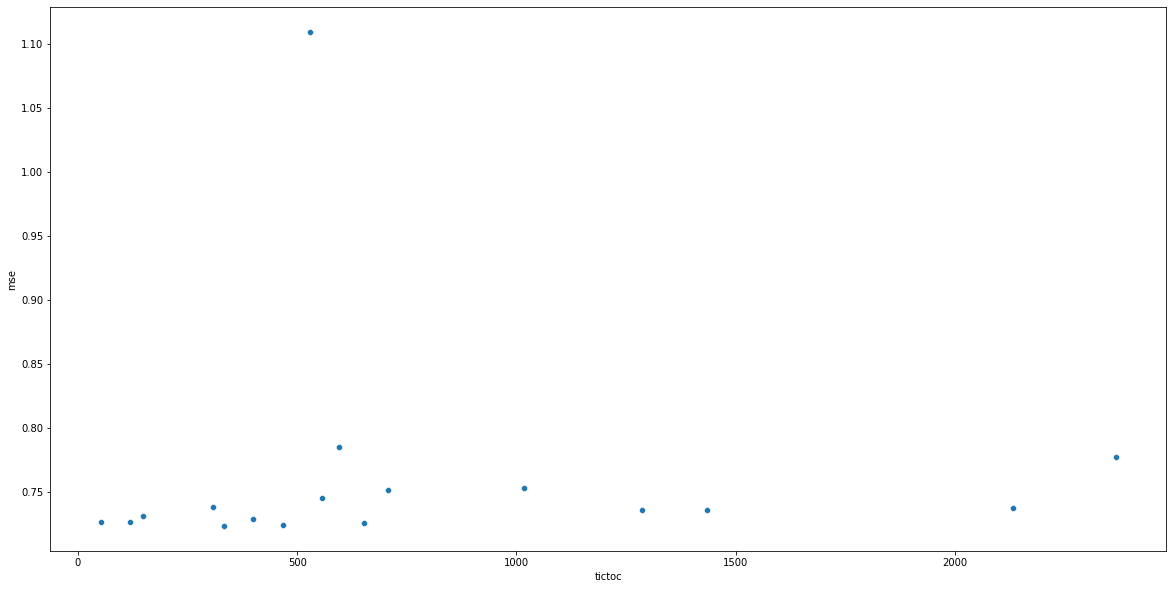

In [30]:
results_df = pd.concat([
    pd.DataFrame([
        {
            **{k:v for k,v in r.items() if k!="hp"}, 
            **r["hp"],
#             "len_f":len(r["hp"].get("features",list(X)))/len(list(X))
        } 
        for r 
        in results
    ]),
#     pd.read_csv(".tmp/save.csv"),
],ignore_index=True)

plt.subplots(figsize=(20,10))
sns.scatterplot(
    data=pd.DataFrame({
        **results_df,
        "tictoc":results_df.tictoc.apply(lambda td:td.total_seconds()),
        "-mse":-results_df.mse
    }),
    x="tictoc",
    y="mse",
#     size="mse",
)

results_df.sort_values(by="mse",ascending=True)

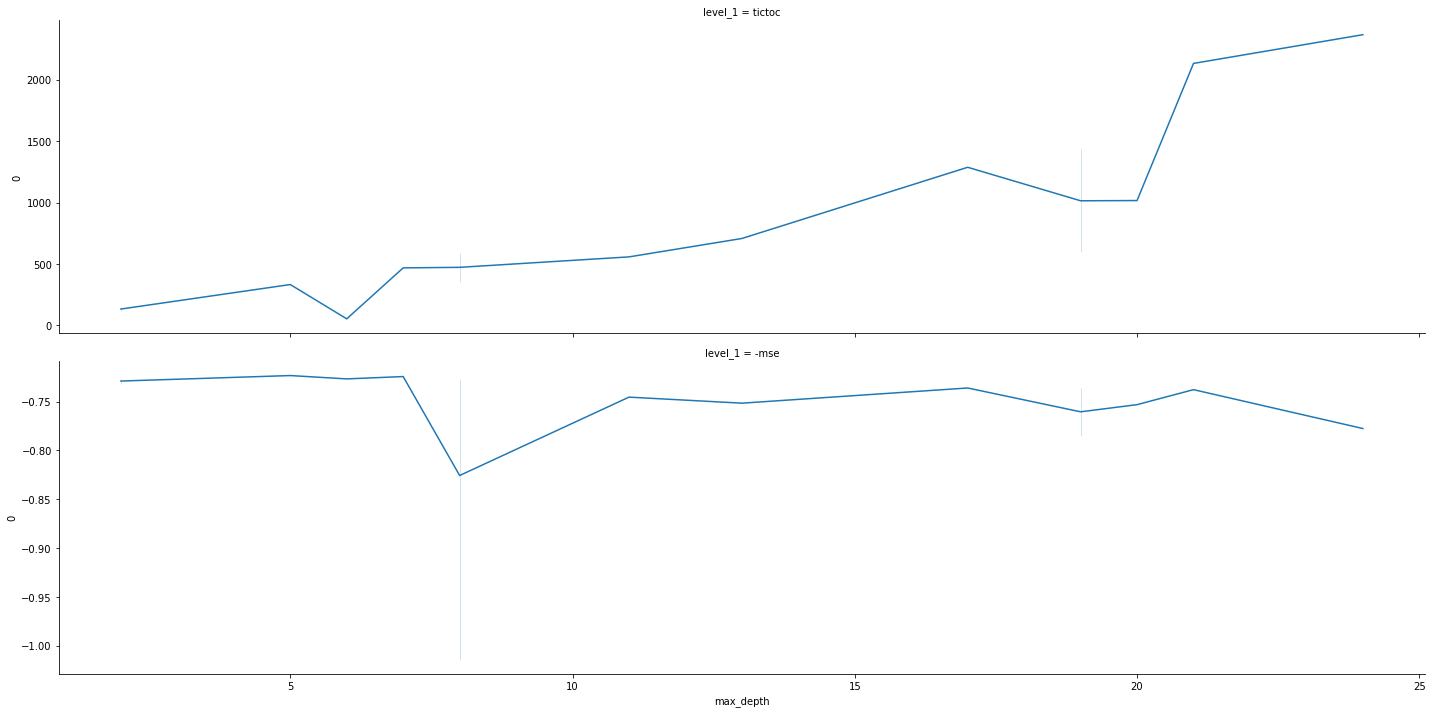

In [72]:
# _FN = "n_estimators"
_FN = "max_depth"
# _FN = "learning_rate"
_df = results_df.set_index(_FN).loc[:,["tictoc","mse"]]
# _df["lmse"] = _df.mse.apply(np.log)
_df["-mse"] = -_df.mse
_df = _df.drop(columns=["mse"])
_df.tictoc = _df.tictoc.apply(lambda td:td.total_seconds())
_df = pd.DataFrame(_df.stack()).reset_index().fillna(6)
# _df = _df.query("learning_rate<=0.5")
_df
sns.relplot(data=_df,x=_FN,y=0,row="level_1",aspect=4,kind="line",facet_kws={"sharey":False})

In [45]:
_df = results_df.sort_values(by="mse")
for best_i,mse in list(zip(_df.i,_df.mse))[:5]:
    best_i
    gain_df = pd.read_csv(f".tmp/gain_{SUBMISSION_DATE.strftime('%Y%m%d')}_{best_i}.csv").sort_values(by="gain",ascending=False)
    print((best_i,mse))
    display(gain_df.head(5))

(10, 0.7232892135278004)


,feature_name,gain
0,cont12,13.874308
2,cat1,13.240883
1,cont10,12.538528
14,cat8,11.396401
4,cont9,9.908872


(7, 0.7243120981693809)


,feature_name,gain
0,cont12,11.433064
1,cont10,10.337678
2,cat1,8.768365
4,cont9,8.162128
3,cont2,6.845405


(15, 0.7259892080575326)


,feature_name,gain
0,cont12,10.181484
1,cont10,9.048719
2,cat1,7.995715
4,cont9,7.151552
3,cont2,5.924230


(3, 0.7264047970676284)


,feature_name,gain
4,cat1,61.409658
0,cont12,33.551458
10,cat8,31.248793
1,cont10,30.478498
3,cont9,29.342539


(0, 0.726716868557117)


,feature_name,gain
0,cont12,13.975204
1,cont10,12.164709
4,cont9,9.975306
2,cat1,9.352026
12,cat8,9.042032


👆 the following features are important

cat:
1. cat 1
1. cat 8
1. cat 9

cont: (same as with high mi!)
1. cont10
1. cont12
1. cont9
1. cont2

## submission

In [32]:
# Use the model to generate predictions
best_i, best_mse = results_df.sort_values(by="i").mse.argmin(), results_df.mse.min()
print(f"best_i: {best_i} => {best_mse}")
for suff in ["","_ot"]:
    common.submit_prediction(
        f".tmp/predictions{suff}_{SUBMISSION_DATE.strftime('%Y%m%d')}_{best_i}.csv",
        competition_name="30-days-of-ml",
        notebook_fn=FN,
        mse=best_mse,
        suff=suff,
    )
print("https://www.kaggle.com/c/30-days-of-ml/submissions")

best_i: 10 => 0.7232892135278004


[master 64414a6d] auto-commit
 1 file changed, 3 insertions(+), 4 deletions(-)


remote: 
remote: GitHub found 7 vulnerabilities on nailbiter/for's default branch (2 high, 5 moderate). To find out more, visit:        
remote:      https://github.com/nailbiter/for/security/dependabot        
remote: 
To https://github.com/nailbiter/for.git
   46f270ee..64414a6d  master -> master
100%|██████████| 3.01M/3.01M [00:09<00:00, 348kB/s] 


Successfully submitted to 30 Days of ML

100%|██████████| 3.01M/3.01M [00:08<00:00, 386kB/s] 


Successfully submitted to 30 Days of ML